In [3]:
from fastai.collab import *
from fastai.tabular import *

### Getting the data

In [4]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest.zip -d {Config.data_path()}

DEBUG output created by Wget 1.19.4 on linux-gnu.

Reading HSTS entries from /root/.wget-hsts
URI encoding = ‘UTF-8’
Converted file name 'ml-latest.zip' (UTF-8) -> 'ml-latest.zip' (UTF-8)
--2020-08-31 13:41:59--  http://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Caching files.grouplens.org => 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
Created socket 3.
Releasing 0x000055cab07023a0 (new refcount 1).

---request begin---
GET /datasets/movielens/ml-latest.zip HTTP/1.1
User-Agent: Wget/1.19.4 (linux-gnu)
Accept: */*
Accept-Encoding: identity
Host: files.grouplens.org
Connection: Keep-Alive

---request end---
HTTP request sent, awaiting response... 
---response begin---
HTTP/1.1 200 OK
Date: Mon, 31 Aug 2020 13:41:59 GMT
Server: Apache/2.4.6 (Red Hat Enterprise Linux) OpenSSL/1.0.2k-fips
Last-Modified: Tue, 03 Dec 2019 17:15:37 GMT
ETag: "10846a59-598c

In [5]:
!unzip /content/ml-latest.zip -d {Config.data_path()}

Archive:  /content/ml-latest.zip
   creating: /root/.fastai/data/ml-latest/
  inflating: /root/.fastai/data/ml-latest/links.csv  
  inflating: /root/.fastai/data/ml-latest/tags.csv  
  inflating: /root/.fastai/data/ml-latest/genome-tags.csv  
  inflating: /root/.fastai/data/ml-latest/ratings.csv  
  inflating: /root/.fastai/data/ml-latest/README.txt  
  inflating: /root/.fastai/data/ml-latest/genome-scores.csv  
  inflating: /root/.fastai/data/ml-latest/movies.csv  


In [6]:
path = Config.data_path()/'ml-latest'
!dir {path}

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [7]:
ratings = pd.read_csv(path/'ratings.csv')

In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [9]:
movies = pd.read_csv(path/'movies.csv')

In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
rating_movie = ratings.merge(movies[['movieId','title']])
## we were required to give movieId because that will be the foreign key for merge

In [12]:
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,1,307,3.5,1256677221,Three Colors: Blue (Trois couleurs: Bleu) (1993)
1,6,307,4.0,832059248,Three Colors: Blue (Trois couleurs: Bleu) (1993)
2,56,307,4.0,1383625728,Three Colors: Blue (Trois couleurs: Bleu) (1993)
3,71,307,5.0,1257795414,Three Colors: Blue (Trois couleurs: Bleu) (1993)
4,84,307,3.0,999055519,Three Colors: Blue (Trois couleurs: Bleu) (1993)


In [13]:
rating_movie.tail()

,userId,movieId,rating,timestamp,title
27753439,282403,167894,1.0,1524243885,Stranglehold (1994)
27753440,282732,161572,3.5,1504408070,The Great Houdini (1976)
27753441,283000,117857,3.5,1417317969,Hotline (2014)
27753442,283000,133409,3.5,1431539331,Barnum! (1986)
27753443,283000,142855,3.5,1442889934,Paul Taylor Creative Domain (2014)


### Creating Databunch object

In [14]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name='title')
# in original notebook everywhere title was usedwithout quotes
# doesnt work here whats the deal

In [15]:
data.show_batch()

userId,title,target
234157,My Best Friend's Wedding (1997),3.0
256458,Tomorrow Never Dies (1997),2.0
47840,Big Nothing (2006),4.0
96771,Joe Versus the Volcano (1990),2.0
49878,"View to a Kill, A (1985)",4.5


### Colab learner

In [16]:
y_range = [0,5.5] # jeremy tactics for the win!

In [17]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

### finding the learning rate

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


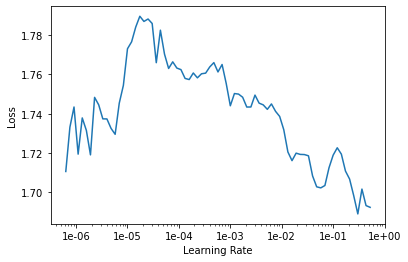

In [19]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time


In [ ]:
learn.save('dotprod')

In [ ]:
learn.export('movielens.pkl')

### Interpretation

In [ ]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

### Movie bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

In [ ]:
mean_ratings = rating_movie.groupby('title')['rating'].mean()

In [ ]:
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies, movie_bias)]

In [ ]:
item0= lambda o:o[0]

In [ ]:
sorted(movie_ratings, key=item0)[:15]

In [ ]:
sorted(movie_ratings,key=item0, reverse=True)

### Movie weights

In [ ]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

In [ ]:
movie_pca = movie_w.pca(4)
movie_pca.shape

In [ ]:
fa0, fa1, fa2, fa3 = movie_pca.t()


In [ ]:
movie_comp_0 = [(f, i) for f, i in zip(fa0, top_movies)]
movie_comp_1 = [(f, i) for f, i in zip(fa1, top_movies)]
movie_comp_2 = [(f, i) for f, i in zip(fa2, top_movies)]
movie_comp_3 = [(f, i) for f, i in zip(fa3, top_movies)]


In [ ]:
sorted(movie_comp_0, key=itemgetter(0))[:10]

In [ ]:
sorted(movie_comp_1, key=itemgetter(0))[:10]


In [ ]:
sorted(movie_comp_2, key=itemgetter(0))[:10]


In [ ]:
sorted(movie_comp_3, key=itemgetter(0))[:10]


In [ ]:
sorted(movie_comp_0, key=itemgetter(0), reverse=True)[:10]


In [ ]:
sorted(movie_comp_1, key=itemgetter(0), reverse=True)[:10]


In [ ]:
sorted(movie_comp_2, key=itemgetter(0), reverse=True)[:10]


In [ ]:
sorted(movie_comp_3, key=itemgetter(0), reverse=True)[:10]


In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fa3[idxs]
Y = fa4[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X,Y)

for i, x, y in zip(top_movies[idxs], X, Y):
  plt.text(x,y,i,color=np.random.rand(3)*0.7, fontsize=11)
plt.show()
